# Test of calibrated parameters and Monte Carlo path simulations

In [24]:
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display
from yahoo_fin import options
from yahoo_fin import stock_info as si
import scipy.optimize as scpo
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
plt.style.use('default')
pio.templates.default = "seaborn"

from functions.BSpricer import BS_Pricer
from functions.MERTONpricer import Merton_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

np.random.seed(110)

In [25]:
T = 1  # Expiry Date in years
days = 252
paths = 10000
r = 0.03 # risk.free interest rate
q = 0
size = (days, paths)
exercise = 'european'

### CALLS CALIBRATED PARAMETERS

In [26]:
spx_data = pd.read_csv('data/sp500_data.csv')
print(spx_data.head())

         Date         Open         High          Low        Close      Volume   
0  2016-01-20  1876.180054  1876.180054  1812.290039  1859.329956  6416070000  \
1  2016-01-21  1861.459961  1889.849976  1848.979980  1868.989990  5078810000   
2  2016-01-22  1877.400024  1908.849976  1877.400024  1906.900024  4901760000   
3  2016-01-25  1906.280029  1906.280029  1875.969971  1877.079956  4401380000   
4  2016-01-26  1878.790039  1906.729980  1878.790039  1903.630005  4357940000   

    Returns  Log Returns  Returns (%)  
0       NaN          NaN          NaN  
1  1.005195     0.005182     0.519544  
2  1.020284     0.020081     2.028370  
3  0.984362    -0.015762    -1.563798  
4  1.014144     0.014045     1.414434  


In [60]:
bs_sigma = 0.13633                              # calibrato il 16/8/23
mert_params = [0.114, 0.4987, -0.0956, 0.0733] # calibrati il 16/8/23 con options nuove
# kou_params = [0.1192, 0.3314, 0.0675, 8.8496, 10.1685]        # calibrazione 16/8/23
kou_params = [0.1192, 0.3314, 0.3675, 8.8496, 10.1685]        # cambiati leggermente perchè erano valori troppo impo
vg_params = [0.1259, 0.1715, 0.1711]                     # calibrazione 16/8/23 (CALLS)

S0 = spx_data.loc[0, 'Close']
symbol = 'SPX'
#### Historical data from SPX Time Series (2016-2018)

In [61]:
otko_spx = pd.read_csv('data/otko_spx_1year.csv')

th_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'Midpoint (%)': otko_spx['Midpoint (%)']
})

strikes = otko_spx[['K1', 'K2']].values / 100

### Black Scholes

(252, 10000)


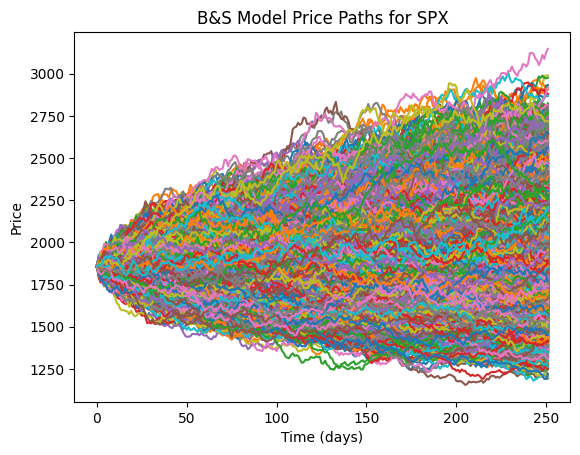

<Figure size 1000x600 with 0 Axes>

In [62]:
BS = BS_Pricer(S0, r, q, bs_sigma, T, exercise, None)
SBlackScholes = BS.BlackScholesPath(days, paths)
BS.plotBSPath(SBlackScholes, symbol)
print(SBlackScholes.shape)

### Merton

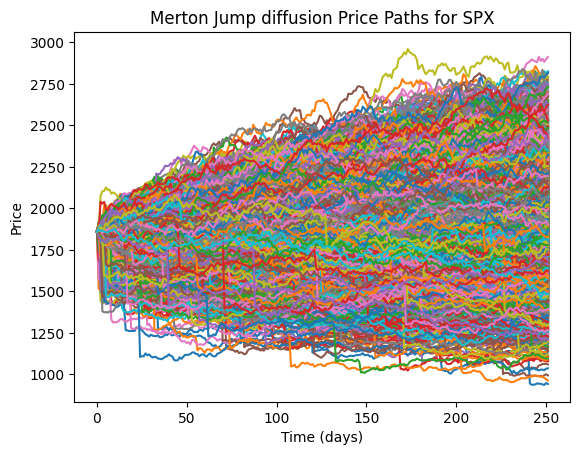

<Figure size 1000x600 with 0 Axes>

In [63]:
MERT = Merton_pricer(S0, None, T, r, q, mert_params[0], mert_params[1], mert_params[2], mert_params[3], exercise)

SMerton = MERT.MertonPath(days, paths)
MERT.plotMertonPath(SMerton, symbol)  # Plot all paths

### Kou JD

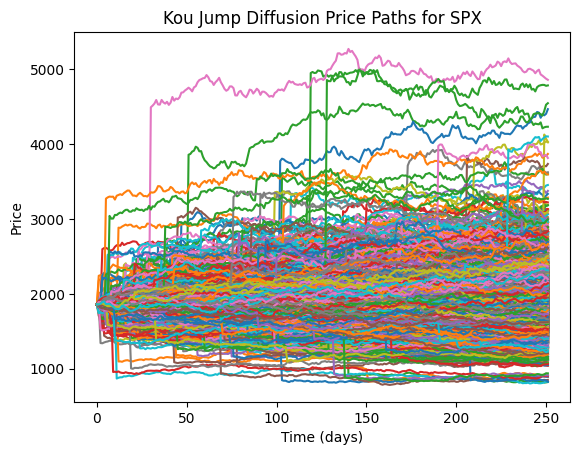

<Figure size 1000x600 with 0 Axes>

In [64]:
KOU = Kou_pricer(S0,None, T, r, kou_params[0], kou_params[1], kou_params[2], kou_params[3], kou_params[4], exercise)
SKou = KOU.KouPath(days, paths)

# Plot all paths
KOU.plotKouPath(SKou, symbol)

In [65]:
avg_final_value = SKou[-1,:].mean()
print(f'KOU Jump Diffusion SPX value after 252 days: {avg_final_value}')

# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou.T:
        payoffs.append(KOU.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))


kou_mc_prices = np.zeros(len(th_prices))
kou_prices_cf = np.zeros(len(th_prices))
for index in range(len(th_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
for i, (K1, K2) in enumerate(zip(otko_spx['K1'].values, otko_spx['K2'].values)):
    kou_prices_cf[i] =KOU.closed_formula_otko(K1/100, K2/100)

th_prices['KOU CF (%)'] = kou_prices_cf
th_prices['KOU MC (%)'] = kou_mc_prices
print(th_prices)


KOU Jump Diffusion SPX value after 252 days: 1911.6710674485064
   K1  K2  Midpoint (%)  KOU CF (%)  KOU MC (%)
0  75   0         0.185    0.067339    0.077400
1  70   0         0.090    0.031182    0.038187
2  85  75         0.370    0.204909    0.233938
3  80  70         0.260    0.107225    0.124629
4  90  80         0.510    0.376822    0.411148


### Variance gamma

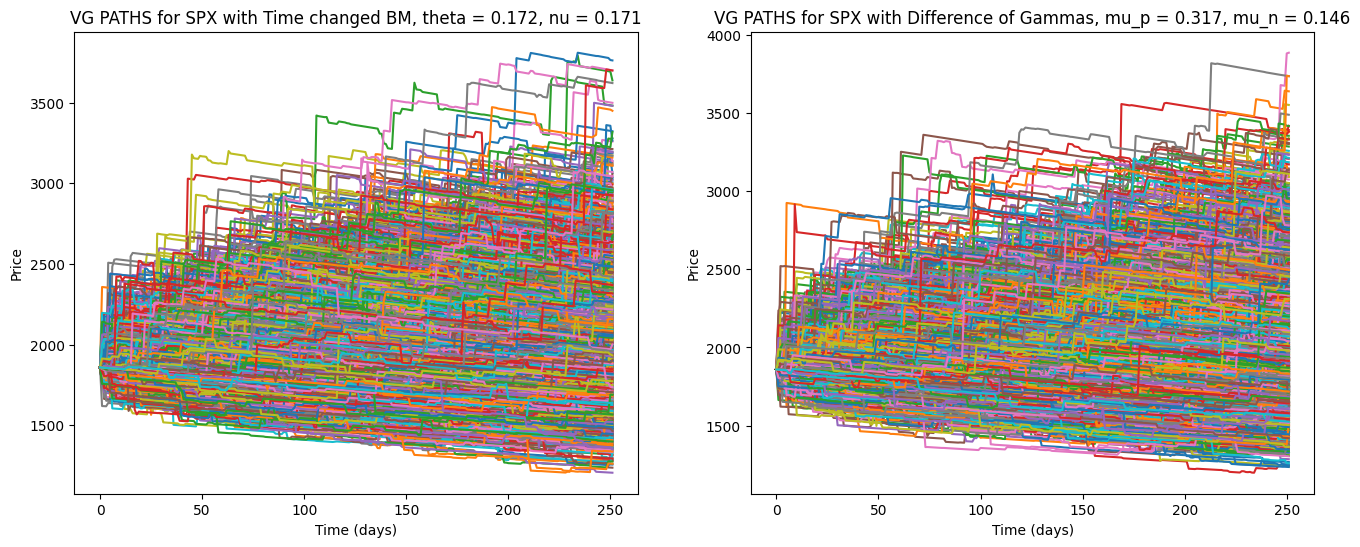

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [66]:
# vg_params = [0.3, -0.01, 0.2]
sigma, theta, nu = vg_params

VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma = VG.VarianceGammaPath1(days, paths)
SVarGamma2 = VG.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
VG.plotVGPath(SVarGamma, symbol, method[0], ax=axes[0])
VG.plotVGPath(SVarGamma2, symbol, method[1], ax=axes[1])
plt.tight_layout()

In [67]:
avg_final_value = SVarGamma[-1,:].mean()
print(f'VG Jump Diffusion SPX value after 252 days: {avg_final_value}')

# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVarGamma2.T:
        payoffs.append(VG.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(th_prices))
vg_prices_cf = np.zeros(len(th_prices))

for index in range(len(th_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]*100
for i, (K1, K2) in enumerate(zip(otko_spx['K1'].values, otko_spx['K2'].values)):
    vg_prices_cf[i] = VG.closed_formula_otko6(K1/100, K2/100)

th_prices['VG CF (%)'] = vg_prices_cf
th_prices['VG MC (%)'] = vg_mc_prices
print(th_prices)

VG Jump Diffusion SPX value after 252 days: 1912.5310554308048
   K1  K2  Midpoint (%)  KOU CF (%)  KOU MC (%)     VG CF (%)  VG MC (%)
0  75   0         0.185    0.067339    0.077400  7.796432e-06   0.000000
1  70   0         0.090    0.031182    0.038187  3.799407e-07   0.000000
2  85  75         0.370    0.204909    0.233938  2.133698e-03   0.000982
3  80  70         0.260    0.107225    0.124629  1.366849e-04   0.000000
4  90  80         0.510    0.376822    0.411148  3.086331e-02   0.029947


In [68]:
# Day-by-day mean of the 1000 paths, for each model
daily_avg = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarGamma1', 'VarGamma2'])
#daily_avg['Days'] = np.linspace(0,251,1)

daily_avg['BlackScholes'] = SBlackScholes.mean(axis=1)
daily_avg['Merton'] = SMerton.mean(axis=1)
daily_avg['Kou'] = SKou.mean(axis=1)
daily_avg['VarGamma1'] = SVarGamma.mean(axis=1)
daily_avg['VarGamma2'] = SVarGamma2.mean(axis=1)
print(daily_avg.tail())



     BlackScholes       Merton          Kou    VarGamma1    VarGamma2
247   1910.700394  1909.456945  1910.347971  1911.962203  1912.426769
248   1910.709952  1909.517598  1910.518585  1911.937903  1912.753180
249   1910.868114  1909.838781  1910.953440  1912.166521  1913.082775
250   1911.338365  1909.962782  1911.329180  1912.409258  1913.314928
251   1911.834198  1910.286423  1911.671067  1912.531055  1913.605944


In [69]:
# TODO: COSA è LA DERIVA VERSO IL BASSO? controlla formule
St = S0 * np.exp(r * T)
print(St)

# Calculate the daily growth factor
daily_growth_factor = np.exp(r/ days)

# Calculate the growth of prices day by day
St = S0 * np.cumprod(np.full(days, daily_growth_factor))

fig1 = go.Figure()
for column in daily_avg.columns:
    fig1.add_trace(go.Scatter(x=spx_data.loc[0:251, 'Date'], y=daily_avg[column], name=column))
fig1.add_trace(go.Scatter(x = spx_data.loc[0:251, 'Date'], y = St, name='Risk-free Growth'))

# Update the layout
fig1.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title = 'Real vs Simulated SPX paths',
    showlegend=True
)

# Show the plot
pio.show(fig1)

### MERTON DRIFT!!!
### CAPIRE KOU e VG come aggiustare drift

1915.9549833321462


### PUTS CALIBRATION. MODEL VALIDATION CHECK

In [70]:
bs_sigma = 0.27918  # [σ]
# MERTON MODEL
mert_params = [0.1382, 0.6087, -0.0842, 0.357]          # calibrazione il 16/8/23 con options nuove
# KOU MODEL
kou_params = [0.2193, 0.7222, 0.4273, 11.2726, 4.5653]         # calibrazione 16/10/23
# VARIANCE GAMMA MODEL
vg_params = [0.2962, 0.0778, 0.6548]                        # calibrazione 16/10/23


#### Monte Carlo Paths Simulation of all the models

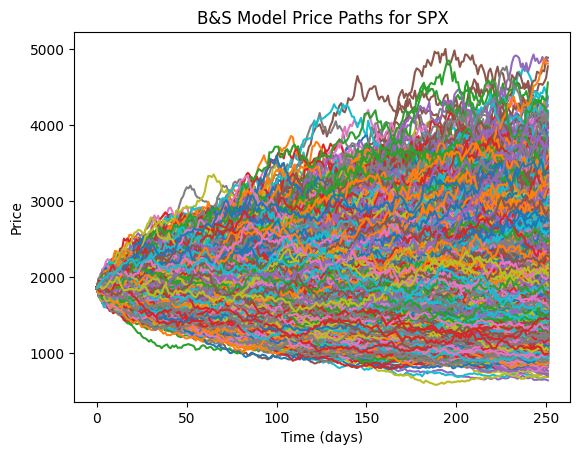

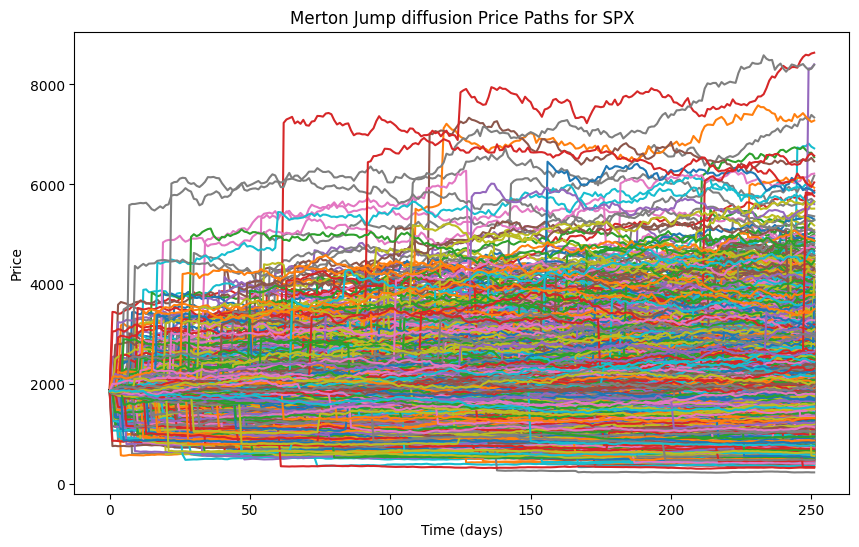

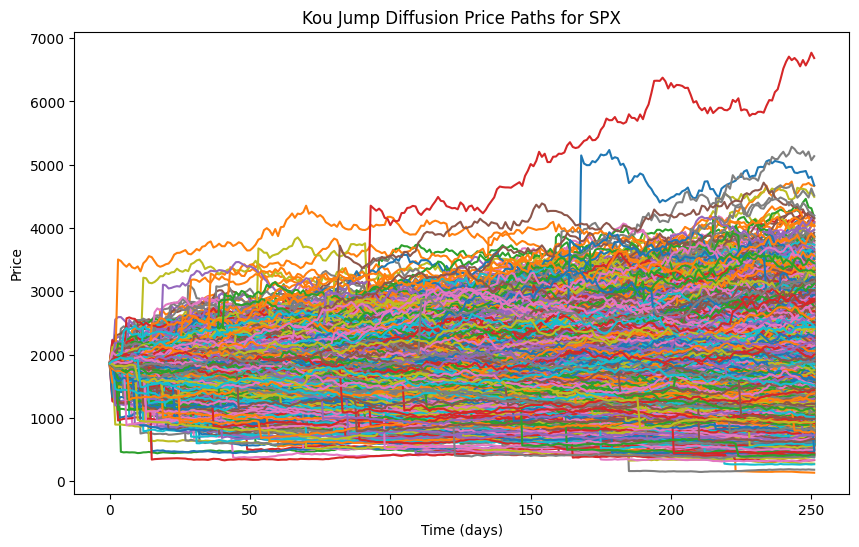

<Figure size 1000x600 with 0 Axes>

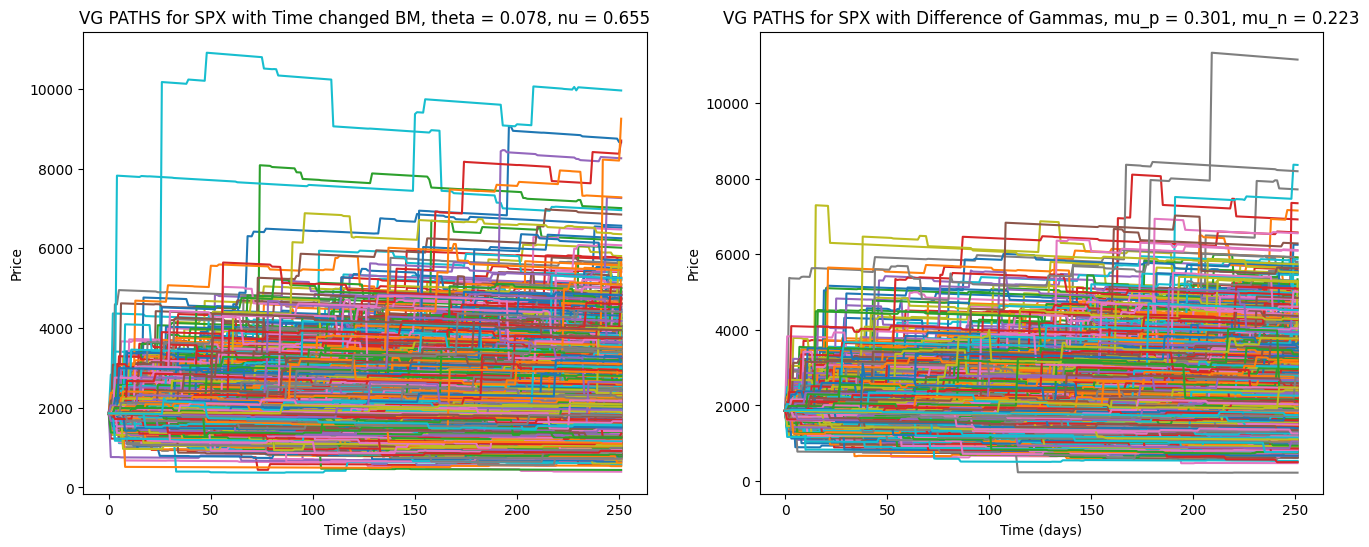

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [71]:
days = 252
paths = 10000

# BLACK SCHOLES
BS = BS_Pricer(S0, r, q, bs_sigma, T, exercise, None)
SBlackScholes = BS.BlackScholesPath(days, paths)
BS.plotBSPath(SBlackScholes, symbol)

# MERTON MODEL
MERT = Merton_pricer(S0, None, T, r, q, mert_params[0], mert_params[1], mert_params[2], mert_params[3], exercise)
SMerton = MERT.MertonPath(days, paths)
MERT.plotMertonPath(SMerton, symbol)  # Plot all paths

# KOU MODEL
KOU = Kou_pricer(S0,None, T, r, kou_params[0], kou_params[1], kou_params[2], kou_params[3], kou_params[4], exercise)
SKou = KOU.KouPath(days, paths)
KOU.plotKouPath(SKou, symbol)

# VARIANCE GAMMA
sigma, theta, nu = vg_params
VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma = VG.VarianceGammaPath1(days, paths)
SVarGamma2 = VG.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
VG.plotVGPath(SVarGamma, symbol, method[0], ax=axes[0])
VG.plotVGPath(SVarGamma2, symbol, method[1], ax=axes[1])
plt.tight_layout()


In [39]:
# Day-by-day mean of the 1000 paths, for each model
daily_avg = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarGamma1', 'VarGamma2'])
#daily_avg['Days'] = np.linspace(0,251,1)

daily_avg['BlackScholes'] = SBlackScholes.mean(axis=1)
daily_avg['Merton'] = SMerton.mean(axis=1)
daily_avg['Kou'] = SKou.mean(axis=1)
daily_avg['VarGamma1'] = SVarGamma.mean(axis=1)
daily_avg['VarGamma2'] = SVarGamma2.mean(axis=1)
print(daily_avg.tail())
# TODO: COSA è LA DERIVA VERSO IL BASSO? controlla formule
St = S0 * np.exp(r * T)
print(St)

# Calculate the daily growth factor
daily_growth_factor = np.exp(r / days)

# Calculate the growth of prices day by day
St = S0 * np.cumprod(np.full(days, daily_growth_factor))

fig1 = go.Figure()
for column in daily_avg.columns:
    fig1.add_trace(go.Scatter(x=spx_data.loc[0:251, 'Date'], y=daily_avg[column], name=column))
fig1.add_trace(go.Scatter(x = spx_data.loc[0:251, 'Date'], y = St, name='Risk-free Growth'))

# Update the layout
fig1.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title = 'Real vs Simulated SPX paths',
    showlegend=True
)

# Show the plot
pio.show(fig1)

### MERTON DRIFT!!!
### CAPIRE KOU e VG come aggiustare drift

     BlackScholes       Merton          Kou    VarGamma1    VarGamma2
247   1915.422793  1912.629019  1909.712173  1917.194905  1905.071453
248   1915.219589  1912.824954  1909.859463  1916.871103  1904.523896
249   1915.938835  1913.240464  1910.236284  1916.651589  1904.516223
250   1915.976377  1912.884159  1910.896736  1916.738500  1904.644014
251   1916.254703  1913.300358  1911.018479  1916.461310  1903.876524
1915.9549833321462
